In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from Utils.Plot_Helper import plot_1d_data
from Utils.Metrics import rmse, nll
from Filters.KalmanFilter import KalmanFilterSmoother
from Systems import UniformNonlinearGrowthModel, BearingsOnlyTracking, BearingsOnlyTrackingTurn
from Experiments.FullSweep import select_transform

In [2]:
def select_data(experiment):
    if experiment == 'ungm':
        exp_table = 'UNGM_EXP'
        con = sqlite3.connect("../Experiments/ungm_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bot':
        exp_table = 'BOT_EXP'
        con = sqlite3.connect("../Experiments/bot_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bott':
        exp_table = 'BOTT_EXP'
        con = sqlite3.connect("../log/bott_final.db", detect_types=sqlite3.PARSE_DECLTYPES)

    cursor = con.cursor()
    return exp_table, cursor


def plot_ep_vs_kalman(cursor, filter_result, smoother_result, seed=101, table_name='UNGM_EXP', trans_id='TT', metric='rmse'):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rmse, nll)'
    metric_ = rmse if metric == 'rmse' else nll
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power=1.0 AND Damping=1.0"
    data = cursor.execute(query_str.format(metric, table_name, trans_id, seed)).fetchall()
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = plot_1d_data(np.array(data).T, c="C3", label="EP", linewidth=2.5, figsize=(8,5))
    ax.axhline(metric_(filter_result, X), c="darkorchid", ls='--', linewidth=2.5, label="UKF")
    ax.axhline(metric_(smoother_result, X), c="c", ls='--', linewidth=2.5, label="UKS")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    return ax


def plot_power_ep_comparison(cursor, power_list, damping_list, seed=101, table_name='UNGM_EXP', trans_id='TT', metric='rmse', colors=['C3', 'yellowgreen', 'grey']):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rmse, nll)'
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power={} AND Damping={}"
    labels = [r'EP ($\alpha={}, \gamma={}$)', r'EP with damping ($\alpha={}, \gamma={}$)', r'Power EP with damping ($\alpha={}, \gamma={}$)']
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = None
    for i, params in enumerate(zip(power_list, damping_list)):
        power, damp = params
        data = cursor.execute(query_str.format(metric, table_name, trans_id, seed, power, damp)).fetchall()
        label = labels[i].format(power, damp)
        ax = plot_1d_data(np.array(data).T, label, colors[i], ax=ax, linewidth=2.5, figsize=(8,5))

    ax.set_xlim(1, 50)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
        
    return ax

Text(0, 0.5, 'RMSE')

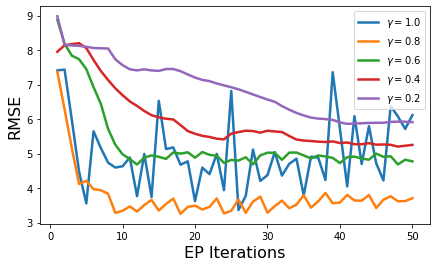

In [3]:
seed = 801
trans = 'UT'
experiment = 'ungm'
metric = 'RMSE'
exp_table, cursor = select_data(experiment)
fig = plt.figure(figsize=(7,4))
ax = fig.gca()
for damp in [1.0, 0.8, 0.6, 0.4, 0.2]:
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power=1.0 AND Damping={}"
    data = cursor.execute(query_str.format(metric, exp_table, trans, seed, damp)).fetchall()
    ax = plot_1d_data(np.array(data).T, label=fr"$\gamma={damp}$", linewidth=2.5, figsize=(8,5), ax=ax)
plt.legend()
plt.xlabel('EP Iterations', fontsize=16)
plt.ylabel(f'{metric}', fontsize=16)

In [4]:
seed = 801
trans = 'UT'
experiment = 'ungm'
exp_table, cursor = select_data(experiment)

# TODO: Resolve issue with loading data from simulation table
np.random.seed(seed=seed)
if experiment == 'ungm':   
    system = UniformNonlinearGrowthModel()
    timesteps = 100
    sys_dim = 1
elif experiment == 'bot':
    system = BearingsOnlyTracking()
    timesteps = 50
    sys_dim = 4
elif experiment == 'bott':
    system = BearingsOnlyTrackingTurn()
    timesteps = 50
    sys_dim = 5

data = system.simulate(timesteps)
X, y = zip(*data)

# Get results from Kalman filter/smoother
transform, meas_transform = select_transform(trans, sys_dim, samples=int(1e4))
f = KalmanFilterSmoother(transform, system, meas_transform)
filter_result = f.kalman_filter(y)
smoother_result = f.kalman_smoother(filter_result)

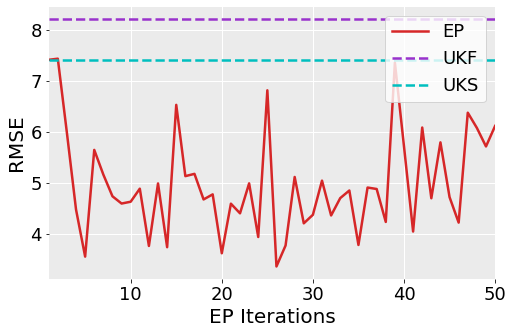

In [5]:
ax = plot_ep_vs_kalman(cursor, filter_result, smoother_result, seed=seed, table_name=exp_table, trans_id=trans)
plt.legend(loc='upper right', fontsize=18)
ax.set_xlim(1, 50)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/EP_Kalman_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

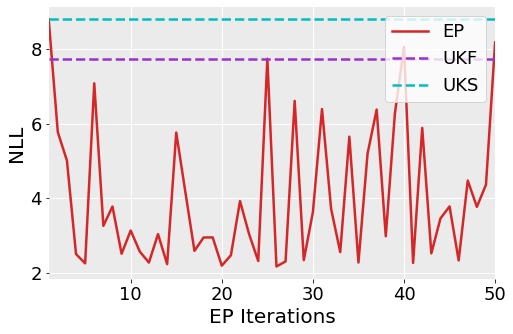

In [6]:
ax = plot_ep_vs_kalman(cursor, filter_result, smoother_result, metric='nll', seed=seed, table_name=exp_table, trans_id=trans)
plt.legend(loc='upper right', fontsize=18)
ax.set_xlim(1, 50)
#ax.set_ylim(1.8, 9.5)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/EP_Kalman_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

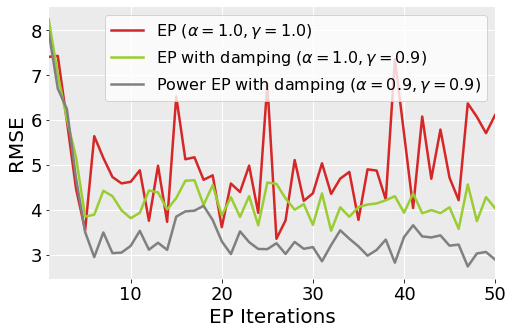

In [7]:
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='rmse')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

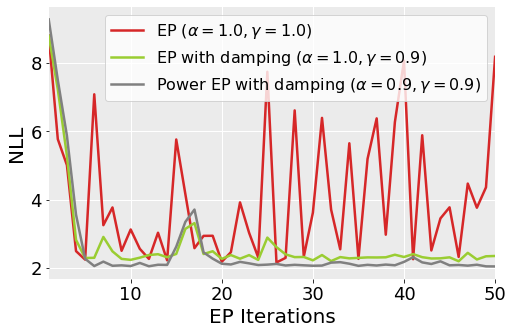

In [8]:
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='nll')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

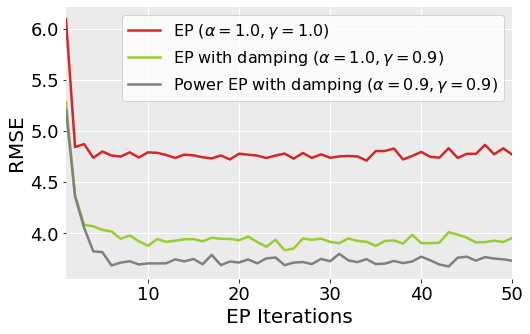

In [9]:
trans = 'MCT'
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='rmse')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

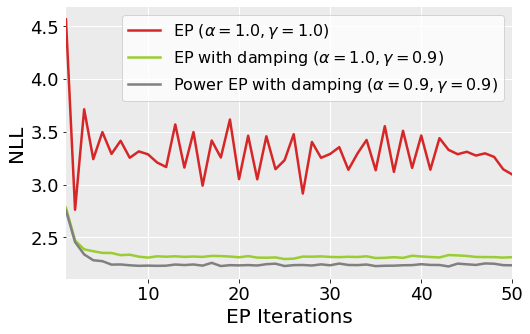

In [10]:
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='nll')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

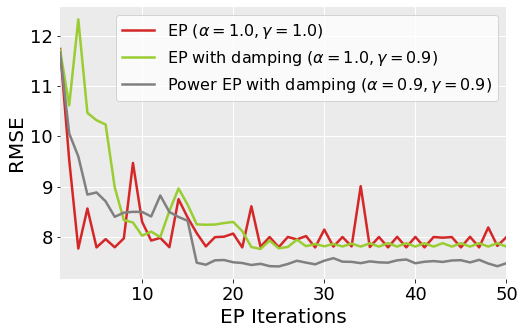

In [11]:
trans = 'TT'
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='rmse')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

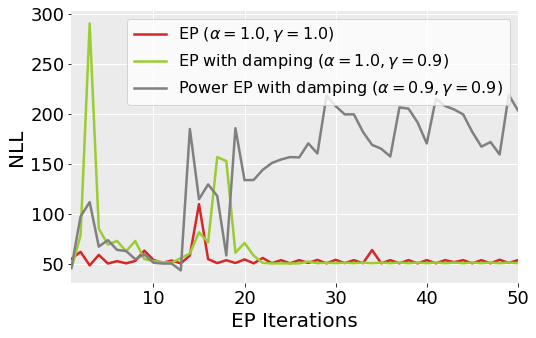

In [12]:
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='nll')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')